# 7.1 Lös advektion-diffution-ekvationen
*I det här problemet får du lösa advektion-diffution-ekvationen med finita element metoden och studera lösningens konvergens när $h \to 0$.*

> ⚠️ För att vara konsekvent med uppgiftsbeskrivningen används $\nabla$ här för att skapa kolumnvektorer. (i föregående uppgifter användes radvektorer)

## a)
Betrakta advektion-diffution-ekvationen $-\varepsilon \Delta u + \beta \cdot \nabla u = f$ med homogena Dirichlet-vilkor på området $\Omega = [-1,1] \times [-1,1]$, diffusion $\varepsilon = 1$ och advektion $\beta(x,y) = \begin{bmatrix} -y & x \end{bmatrix}^\top$. Verifiera (analytiskt) att $\beta$ är divergensfirtt, att $u(x,y) = (1-x^2)(1-y^2)$ uppfyller randvilkoren och bestäm högerledet $f$ så att $u$ löser ekvationen.

> RE: Homogena Dirichlet-villkor<br>
> $u = 0$ längs randen av området $\Omega$<br>
> $V_{h,D} = V_{h,0}$<br>
> $\Gamma_R = \emptyset\enspace$ ( $\Gamma_R$ är tom)<br>

> RE:
> $\beta(x,y) = \begin{bmatrix} \beta_1(x,y) \\ \beta_2(x,y) \end{bmatrix} = \begin{bmatrix} -y \\ x \end{bmatrix}$

### a.1) $\beta$ är divergensfritt
$= \nabla \cdot \beta(x,y)$

$= \frac{\partial \beta_1}{\partial x} + \frac{\partial \beta_2}{\partial y}$
$= \frac{\partial (-y)}{\partial x} + \frac{\partial (x)}{\partial y}$
$= 0 + 0$
$=0$

✅, $\beta$ är divergensfitt

### a.2) Randvilkor uppfylls

Randen av $\Omega$ kan delas upp i 4 delsträckor.<br>
![alt text](images/7-area.png)

$C_1: u(1, y) = (1-1^2)(1-y^2) = 0$<br>
$C_2: u(-1, y) = (1-(-1)^2)(1-y^2) =0$<br>
$C_3: u(x, 1) = (1-x^2)(1-1^2) = 0$<br>
$C_4: u(x, -1) = (1-x^2)(1-(-1)^2) = 0$<br>

✅, Randvilkoren uppfylls

### a.3) Högerledet

$f =-\varepsilon \Delta u + \beta \cdot \nabla u$

> RE: $\varepsilon = 1$

$\varepsilon\Delta u = \displaystyle\frac{\partial^2 u}{\partial x^2} + \displaystyle\frac{\partial^2 u}{\partial y^2}$<br>
$\displaystyle\frac{\partial^2 u}{\partial x^2} = \displaystyle\frac{\partial}{\partial x}\Big(-2x(1-y^2) \Big) = -2(1-y^2)$<br>
$\displaystyle\frac{\partial^2 u}{\partial y^2} = \displaystyle\frac{\partial}{\partial y}\Big(-2y(1-x^2) \Big) = -2(1-x^2)$<br>

$\varepsilon\Delta u = -2(2-x^2-y^2)$<br>
$-\varepsilon\Delta u = 2(2-x^2-y^2)$

$\def\arraystretch{1.5}\beta \cdot \nabla u = \begin{bmatrix} -y \\ x \end{bmatrix} \cdot \begin{bmatrix} \frac{\partial}{\partial x} (1-x^2)(1-y^2) \\ \frac{\partial}{\partial y} (1-x^2)(1-y^2) \end{bmatrix}$

$= \begin{bmatrix} -y \\ x \end{bmatrix} \cdot \begin{bmatrix} \frac{\partial}{\partial x} -2x(1-y^2) \\ \frac{\partial}{\partial y} -2y(1-x^2) \end{bmatrix}$

$= 2xy(1-y^2) - 2xy(1-x^2)$

$\beta \cdot \nabla u = 2xy(x^2-y^2)$

Tillsammans:

$f =-\varepsilon \Delta u + \beta \cdot \nabla u$<br>
$= 2(2-x^2-y^2) - 2xy(x^2-y^2)$

✅, $f$ är löst



# b) Lös randvärdesproblemet

In [1112]:
# Utility Code
import numbers
from typing import Annotated, Any, Literal
from numpy import floating, ndarray
import numpy as np

type Matrix2x2 = ndarray[tuple[Literal[2], Literal[2]], floating]
type Matrix3x3 = ndarray[tuple[Literal[3], Literal[3]], floating]
type Vector2 = ndarray[tuple[Literal[2], Literal[1]], floating]
type Vector3 = ndarray[tuple[Literal[3], Literal[1]], floating]

def npfmt(arr: ndarray) -> str:
    def fmt(a: float|list) -> str:
        if isinstance(a, list):
            if len(a) == 1:
                return fmt(a[0])
            return "[" + ", ".join(fmt(i) for i in a) + "]"
        if isinstance(a, numbers.Real):
            if a >= 0:
                return f" {a:3f}"
            else:
                return f"{a:3f}"
    return fmt(arr.tolist())

## b.1) Funktioner för Triangulisering

In [1113]:
from dataclasses import dataclass
from functools import cached_property
import matplotlib.pyplot as plt
import matplotlib.tri as tri

@dataclass
class TriangulatedGrid:
    # Vertex
    # [[x₀, y₀], [x₁, y₁], ...]
    V: ndarray[Vector2]

    # Högerorienterad lista av vertexindex
    # [[i₀, j₀, k₀], [i₁, j₁, k₁], ...]
    K: ndarray[Vector3]

    def __init__(
            self,
            nx: int, ny: int,
            xmin: int = 0, xmax: int = 1,
            ymin: int = 0, ymax: int = 1,
        ):
        V = []
        K = []

        n_vertecies_in_a_row = nx+1
        n_vertecies_in_a_column = ny+1

        for y in np.linspace(ymin, ymax, n_vertecies_in_a_column):
            for x in np.linspace(xmin, xmax, n_vertecies_in_a_row):
                V.append(np.asarray([[x], [y]]))

        # iterera genom varje hörn som har noder till höger och ovanför sig
        for y in range(ny):
            for x in range(nx):
                # Beräkna index i triangelhörnen har V
                p1 = y * n_vertecies_in_a_row + x   # Botten/Vänster hörn
                p2 = p1 + 1                         # Botten/Höger hörn
                p3 = p1 + n_vertecies_in_a_row      # Topp/Vänster corner
                p4 = p3 + 1                         # Topp/Höger corner

                # Definera de två trinaglarna motsols! (högerorienterad)
                # 3-4
                # |\|
                # 1-2
                K.append(np.asarray([[p1], [p3], [p2]]))  # Botten/Höger triangel
                K.append(np.asarray([[p4], [p2], [p3]]))  # Topp/Vänster triangel

        self.V = np.asarray(V)
        self.K = np.asarray(K)

        assert len(self.K) == 2*nx*ny, f"{len(self.K)=} ?= {2*nx*ny}"

    @cached_property
    def xs(self)-> ndarray[floating]:
        """ returnerar x koordinaterna för vetexen (i ordning)
            ex: [x₀, x₁, x₂, ...] """
        return self.V[:, 0, 0]

    @cached_property
    def ys(self) -> ndarray[floating]:
        """ returnerar y koordinaterna för vetexen (i ordning)
            ex: [y₀, y₁, y₂, ...] """
        return self.V[:, 1, 0]

    @cached_property
    def triangulation(self) -> tri.Triangulation:
        """ returnerar en matplotlib Triangulation av nätet """
        return tri.Triangulation(self.xs, self.ys, self.K[:, :, 0])

    @cached_property
    def K_coords(self) -> ndarray[ndarray[Vector2]]:
        """ returnerar en array av koordinaterna för K (istället för vertexindex) """
        return self.V[self.K][:, :, 0, :]

    @cached_property
    def K_with_coords(self) -> list[tuple[Vector3, ndarray[Vector2]]]:
        """ returnerar en iterator av formen
        (K[i], array of K[i]:s noders positioner)
        ex: ([Vec3[i₀,i₁,i₄], [Vec2[x₀, y₀], Vec2[x₁, y₁], Vec2[x₄, y₄]])...
        """
        return list(zip(self.K, self.K_coords))

def generate_mesh_2d(nx: int, ny: int) -> tuple[ndarray, ndarray]:
    trigrid = TriangulatedGrid(nx=nx, ny=ny)
    return (trigrid.V, trigrid.K)


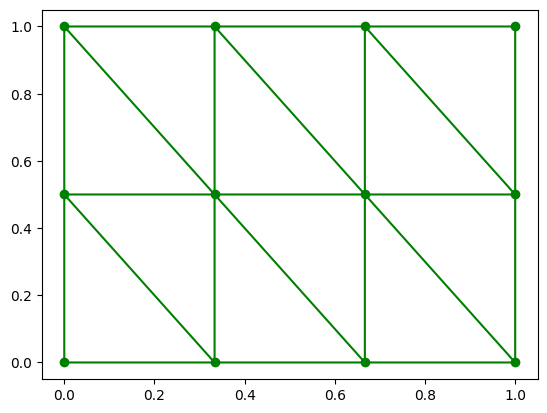

In [1114]:
def plot_mesh_2d(trigrid: TriangulatedGrid):
    plt.triplot(trigrid.triangulation, 'go-', lw=1.5)

plot_mesh_2d(TriangulatedGrid(nx=3, ny=2))

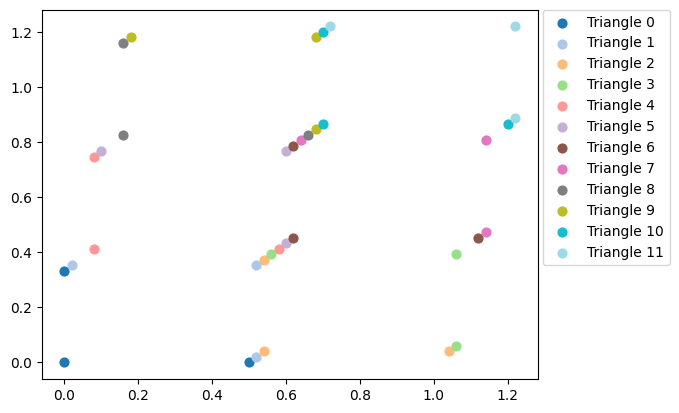

In [1115]:
# !Bonus! för att dubbelkolla att k_coords är korrekt
def test_k_coords(trigrid: TriangulatedGrid):
    k_wpos = trigrid.K_with_coords
    n_sets = len(k_wpos)
    colors = plt.cm.tab20(np.linspace(0, 1, n_sets))
    for i, (idxs, coords) in enumerate(k_wpos):
        #print(idxs.tolist())
        #print(coords.tolist())
        coords: ndarray[Vector2]
        xs = coords[:, 0, 0]
        ys = coords[:, 1, 0]

        o = i/50
        plt.scatter(xs+o, ys+o, color=colors[i], s=40, label=f"Triangle {i}")
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
test_k_coords(TriangulatedGrid(nx=2, ny=3))

## b.2) Funktioner för basevaluering

För 2d är basfunktionerna definierade enligt följande:

$\begin{matrix}
\varphi_1(x,y) = a_1 + b_1x + c_1y\\
\varphi_2(x,y) = a_2 + b_2x + c_2y\\
\varphi_3(x,y) = a_3 + b_3x + c_3y\\
\end{matrix} \iff \begin{bmatrix}
\varphi_1(x,y) \\
\varphi_2(x,y) \\
\varphi_3(x,y) \\
\end{bmatrix} = \begin{bmatrix}
a_1 & b_1 & c_1 \\
a_2 & b_2 & c_2 \\
a_3 & b_3 & c_3 \\
\end{bmatrix}\begin{bmatrix}
1\\x\\y\\
\end{bmatrix}$

> ⚠️ åtminstånde innanför triangeln, utanför simplexen är alla $\varphi$ = 0

Om vi låter triangels hörn vara $\left[\begin{smallmatrix}x_1\\y_1\end{smallmatrix}\right], \left[\begin{smallmatrix}x_2\\y_2\end{smallmatrix}\right], \left[\begin{smallmatrix}x_3\\y_3\end{smallmatrix}\right]$ kan vi sätta upp ett ekvationssystem

$\varphi_1(x_1,y_1)=1$, $\varphi_1(x_2,y_2)=0$, $\varphi_1(x_3,y_3)=0$<br>
$\varphi_2(x_1,y_1)=0$, $\varphi_2(x_2,y_2)=1$, $\varphi_2(x_3,y_3)=0$<br>
$\varphi_3(x_1,y_1)=0$, $\varphi_3(x_2,y_2)=0$, $\varphi_3(x_3,y_3)=1$<br>

Skriv upp ekvationen som en matris:

$\begin{bmatrix}
a_1 & b_1 & c_1 \\
a_2 & b_2 & c_2 \\
a_3 & b_3 & c_3 \\
\end{bmatrix} \begin{bmatrix}
  1 &   1 &   1 \\
x_1 & x_2 & x_3 \\
y_1 & y_2 & y_3 \\
\end{bmatrix} = \begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1\\
\end{bmatrix} = AB = I$

$\iff A = B^{-1}$

För referensbasfunktionerna $\varphi$ blir $A$ mycket snäll att lösa: i de flesta andra situationer är det komplicerat.

$\begin{bmatrix}
1 & -1 & -1\\
0 & 1 & 0\\
0 & 0 & 1\\
\end{bmatrix}$

Altså:

$\hat{\varphi}_1(\hat{x}, \hat{y}) = 1-\hat{x}-\hat{y}$<br>
$\hat{\varphi}_2(\hat{x}, \hat{y}) = \hat{x}$<br>
$\hat{\varphi}_3(\hat{x}, \hat{y}) = \hat{y}$<br>

Ideen med använda referensbasfunktionerna är att denna formel är mycket enkel beräkna. Om vi kan transformera en godtycklig triangel till refernsbasen, lösa problemet där och sen transformera tillbaka blir det lättare att lösa problem.


> RE: vi visade i uppgift 8 att:
>
> $\nabla\varphi(x) = \left(F_K'\right)^{-\top}\cdot\hat{\varphi}'\left(F_K^{-1}(x)\right)$
>
> $\nabla\varphi(x) = (F_K')^{-\top}\cdot\nabla_{\hat{x}}\hat{\varphi}(F_K^{-1}(x))$
>
> $\nabla\varphi(x) = (\nabla_{\hat{x}}F_K)^{-\top}\cdot\nabla_{\hat{x}}\hat{\varphi}(F_K^{-1}(x))$
>
> $\nabla\varphi = (F_K')^{-\top} \cdot \nabla_{\hat{x}}\hat{\varphi} \circ F_K^{-1}$

In [1116]:
def referensbas_phi(i: int, pos: Vector2) -> float:
    (x,), (y,) = pos
    match i:
        case 1: return 1-x-y
        case 2: return x
        case 3: return y
        case _: raise ValueError("Not a valid base index")

def referensbas_nabla_phi(i: int, pos: Vector2) -> Vector2:
    # I 2d trianglar spelar det ingen roll vad argumentet till ∇_x̂ φ är
    (x,), (y,) = pos
    match i:
        case 1: return np.asarray([[-1], [-1]])
        case 2: return np.asarray([[ 1], [ 0]])
        case 3: return np.asarray([[ 0], [ 1]])
        case _: raise ValueError("Not a valid base index")

def evaluate_basis_2d(
        i: int,
        x: Vector2,
        X: ndarray[Vector2]
    ) -> tuple[Annotated[float, "φ"], Annotated[Vector2, "∇φ"]]:
    """
    i: val of referensbas [1, 3]
    x: vilken position att evaluera på
    X: vilka positioner hörnen i den lokala triangeln har
    """
    #============ SETUP =============#
    # Gör triangelhörnern till till kolumnvektorer
    v1: Vector2 = X[0]
    v2: Vector2 = X[1]
    v3: Vector2 = X[2]

    # RE> ekvation 5.82
    F_k_jacobi: Matrix2x2 = np.hstack([v2-v1, v3-v1])

    # RE> ekvation 5.81
    # Fₖ(x̂) = x
    # Fₖ⁻¹(x) = x̂
    # Fₖ(x̂) = Ax̂+b
    # => Fₖ⁻¹(x) = A⁻¹(x-b)
    A: Matrix2x2 = np.hstack([v2-v1, v3-v1])
    b: Vector2   = v1
    def F_k_inv(v: Vector2) -> Vector2:
        return np.linalg.inv(A) @ (v - b)

    #============ BÖRJA LÖSA PROBLMET =============#
    local_x: Vector2 = F_k_inv(x)

    # RE> Ekvation 5.88
    phi = referensbas_phi(i, local_x)

    # RE> sats 5.3 / Uppgift 8
    nabla_phi = np.linalg.inv(F_k_jacobi).T @ (
        referensbas_nabla_phi(i, local_x)
    )

    return phi, nabla_phi

In [1117]:
def test_evaluate_basis_2d():
    def test(i, x, X):
        phi, nabla_phi = evaluate_basis_2d(i=i, x=x, X=X)
        print(f"{i=} -> φ={float(phi)}, ∇φ={npfmt(nabla_phi)}")

    p: Vector2 = np.asarray([[0.5], [0.5]])
    X: ndarray[Vector2] = np.asarray([[[0],[0]], [[1],[0]], [[0],[1]]])

    print("Verifiera mitten")
    test(i=1, x=p, X=X)
    test(i=2, x=p, X=X)
    test(i=3, x=p, X=X)

    for im1, corner in enumerate(X):
        i = im1+1
        print(f"Verifiera hörn {i}")
        test(i=1, x=corner, X=X)
        test(i=2, x=corner, X=X)
        test(i=3, x=corner, X=X)

test_evaluate_basis_2d()

Verifiera mitten
i=1 -> φ=0.0, ∇φ=[-1.000000, -1.000000]
i=2 -> φ=0.5, ∇φ=[ 1.000000,  0.000000]
i=3 -> φ=0.5, ∇φ=[ 0.000000,  1.000000]
Verifiera hörn 1
i=1 -> φ=1.0, ∇φ=[-1.000000, -1.000000]
i=2 -> φ=0.0, ∇φ=[ 1.000000,  0.000000]
i=3 -> φ=0.0, ∇φ=[ 0.000000,  1.000000]
Verifiera hörn 2
i=1 -> φ=0.0, ∇φ=[-1.000000, -1.000000]
i=2 -> φ=1.0, ∇φ=[ 1.000000,  0.000000]
i=3 -> φ=0.0, ∇φ=[ 0.000000,  1.000000]
Verifiera hörn 3
i=1 -> φ=0.0, ∇φ=[-1.000000, -1.000000]
i=2 -> φ=0.0, ∇φ=[ 1.000000,  0.000000]
i=3 -> φ=1.0, ∇φ=[ 0.000000,  1.000000]


## b.3) Funktioner för att visualisera nätet

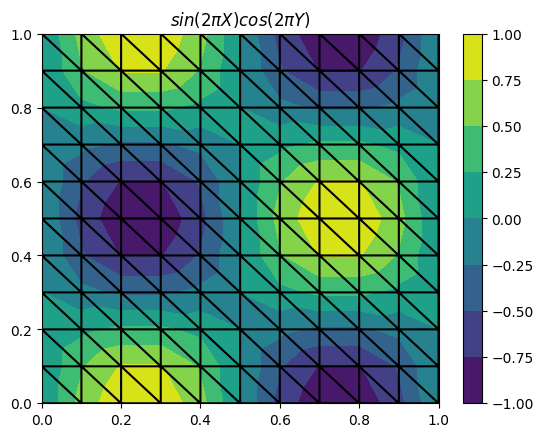

In [1118]:
def show_trigrid_evaluated(trigrid: TriangulatedGrid, values, title: str = "<No Title>"):
    triag = trigrid.triangulation
    plt.title(title)
    plt.tricontourf(triag, values, cmap="viridis")
    plt.triplot(triag, "k-")
    plt.colorbar()
    plt.show()

def show_trigrid_evaluated_example(trigrid: TriangulatedGrid):
    # Godtycklig funktion
    values = np.sin(2*np.pi*trigrid.xs) * np.cos(2*np.pi*trigrid.ys)
    show_trigrid_evaluated(trigrid, values, title="$sin(2πX)cos(2πY)$")

show_trigrid_evaluated_example(TriangulatedGrid(10, 10))

## b.4) Härledning av Styvhetsmatris för advektions-diffusion

> RE: Uppgiftsdefinition
>
> Bok: $\quad\nabla \cdot -\kappa \nabla u + \beta \cdot \nabla u = f$
>
> Uppgift: $\quad-\varepsilon \Delta u + \beta \cdot \nabla u = f$

> RE: Laplacianen (~ekvation 6.3)
>
> $\Delta u = \nabla \cdot \nabla u$

> RE: Styvhetsmatris i 1d, (stationär värmeledning) (6.123)
>
> $\displaystyle\sum_{j=1}^N U_j
\underbrace{\int_\Omega \kappa \nabla\varphi_j \cdot \varphi_i dx + {\int_\Gamma}_R \gamma \varphi_j \varphi_i ds}_{\large a_{ij}} = \underbrace{\int_\Omega f\varphi_i dx + {\int_\Gamma}_R (g_R + \gamma u_R) \varphi_i ds}_{\large b_{i}}$

> RE: Styvhetsmatris i 1d, (stationär värmeledning) där $\Gamma_R = \empty$
>
> $\displaystyle\sum_{j=1}^N U_j
\underbrace{\int_\Omega \kappa \nabla\varphi_j \cdot \varphi_i dx}_{\large a_{ij}} = \underbrace{\int_\Omega f\varphi_i dx}_{\large b_{i}}$
>
> Altså: $AU = b$
>
>> RE: stationär värmeledning
>>
>> $\nabla \cdot (-\kappa \nabla u) = f = -\kappa \Delta u$

Nu vill vi sätta upp styvhetsmatrisen/lastvektorn för advektions-diffusions-ekvationen med  $\Gamma_R = \empty$

$f = f_1 + f_2 = -\varepsilon \Delta u + \beta \cdot \nabla u$
<br>$f_1 = -\varepsilon \Delta u = \nabla \cdot (-\varepsilon \nabla u)$
<br>$f_2 = \beta \cdot \nabla u$

Vi väjer $\varphi_i$ som testfunktion

$\displaystyle\int_\Omega (\nabla \cdot (-\varepsilon \nabla u) + \beta \cdot \nabla u) \varphi_i dx = \displaystyle\int_\Omega f\varphi_i dx$

$\displaystyle\int_\Omega \left(\nabla \cdot \left(-\varepsilon \nabla u \right)\right) \varphi_i dx + \displaystyle\int_\Omega \left(\beta \cdot \nabla u \right) \varphi_i dx = \displaystyle\int_\Omega f_1\varphi_i dx + \displaystyle\int_\Omega f_2\varphi_i dx$

Vi skriver om vänstra integralen och $f_1$ mha divergenssatsen (samma som värmeledning)

> RE:
>
> $\int_\Omega \nabla \cdot (-\kappa \nabla u) v dx = \int_\Omega f v dx$
>
> $\iff$
>
> $\displaystyle\int_\Omega \kappa \nabla u \cdot \nabla v dx + {\int_\Gamma}_R \gamma uv ds = \int_\Omega fv dx + {\int_\Gamma}_R \gamma (g_R + \gamma u_R) v ds $

Med $\Gamma_R = \empty$ får vi:

$\displaystyle\int_\Omega \varepsilon \nabla u \cdot \nabla \varphi_i dx + \displaystyle\int_\Omega \left(\beta \cdot \nabla u \right) \varphi_i dx = \displaystyle\int_\Omega f_1\varphi_i dx + \displaystyle\int_\Omega f_2\varphi_i dx$

Vi sätter ihop $f_1$ och $f_2$ igen då dom lämnades opåverkade av divergenssatstransformationen.

$\displaystyle\int_\Omega \varepsilon \nabla u \cdot \nabla \varphi_i dx + \displaystyle\int_\Omega \left(\beta \cdot \nabla u \right) \varphi_i dx = \displaystyle\int_\Omega f\varphi_i dx$


Vi skriver nu om med den svaga formen

> RE: (6.128)
>
> $u_h = \displaystyle\sum_{j=1}^N U_j\varphi_j$

$\displaystyle\int_\Omega \varepsilon \nabla \left[\displaystyle\sum_{j=1}^N U_j\varphi_j\right] \cdot \nabla \varphi_i dx + \displaystyle\int_\Omega \left(\beta \cdot \nabla \left[\displaystyle\sum_{j=1}^N U_j\varphi_j\right] \right) \varphi_i dx = \displaystyle\int_\Omega f\varphi_i dx$


Vi tar ut det som är obeoende av $x$ från integralerna

$\displaystyle\sum_{j=1}^N U_j \left[ \displaystyle\int_\Omega \varepsilon \nabla \varphi_j \cdot \nabla \varphi_i dx + \displaystyle\int_\Omega \left(\beta \cdot \nabla \varphi_j \right) \varphi_i dx \right] = \displaystyle\int_\Omega f\varphi_i dx$

$\displaystyle\sum_{j=1}^N U_j \displaystyle\int_\Omega \left( \varepsilon \nabla \varphi_j \cdot \nabla \varphi_i + \left(\beta \cdot \nabla \varphi_j \right) \varphi_i \right) dx = \displaystyle\int_\Omega f\varphi_i dx$

Till sist skriver vi om det som en matris multiplikation

$\displaystyle\sum_{j=1}^N U_j \underbrace{\displaystyle\int_\Omega \left(\varepsilon \nabla \varphi_j \cdot \nabla \varphi_i + \beta \cdot \nabla \varphi_j \varphi_i \right) dx}_{A_{ij}} = \underbrace{\displaystyle\int_\Omega f\varphi_i dx}_{B_i}$

$AU = B$

> ⚠️ Notera att $B$ är en kolumnvektor trots att jag här använder stor bokstav. Detta för att inte förvirra denna med $a,b,a_K,b_K$ som används i nästa stycke

> RE: Kovertering mellan matrismultiplikation och summor
>
> $X \in \mathbb{R}^{m \times n}$, $Y \in \mathbb{R}^{n \times w}$
>
> $(X \cdot Y)_i = \displaystyle\sum_{k\in \{1 \dots n\}} X_{ik} \cdot Y_{k}$

## b.5) Assemblering

Vi börjar med att införa följande betckning för att slippa skriva ut hela vår integral.

$A_{ij} = \underbrace{\int_{\Omega} (\varepsilon \nabla \varphi_j \cdot \nabla \varphi_i + \left(\beta \cdot \nabla \varphi_j \right) \varphi_i) dx}_{a(\varphi_i, \varphi_j)}$

$B_{i} = \underbrace{\int_{\Omega} f\varphi_i dx}_{b(\varphi_i)}$

En naiv beräking av styhetsmatrisen och lastvektorn kan göras enligt följande:

$\text{for } i = 1,2, \dots , \#V$<br>
$\quad\text{for } i = 1,2, \dots , \#V$<br>
$\quad\quad A_{ij} = a(\varphi_i, \varphi_j)$

$\text{for } i = 1,2, \dots , \#V$<br>
$\quad b_{ij} = b(\varphi_i)$

Men vi kan vara fiffigare då $\varphi_i/\varphi_j$ är noll nästan överallt

Istället för att iterara genom varje $a_{ij}$ och sen för varje triangel i nätet aproximera integralen kan vi spara mycket arbete genom itera genom varje triangel och endast addera effekterna på de $a_{ij}$ som påverkas av triangeln.

$A_{ij} = \displaystyle\sum_{K \in {\cal K}} \underbrace{\int_{\Omega_K} (\varepsilon \nabla \varphi_j \cdot \nabla \varphi_i + \left(\beta \cdot \nabla \varphi_j \right) \varphi_i) dx}_{a_K(\varphi_i, \varphi_j)}$

$B_{i} = \displaystyle\sum_{K \in {\cal K}} \underbrace{\int_{\Omega_K} f\varphi_i dx}_{b_K(\varphi_i)}$

Där $\Omega_K$ är den högerorienterad ytan som bildas av de tre triangelpunkter i respektive triangel av ${\cal K}$ och $a_K$/$b_K$ är triangeln $K$:s tillskott.

> RE: $({\cal V}, {\cal K})$ är trianguliseringen av $\Omega$

Med denna omskrivning har vi fortfarande inte tjänat något, men nästa optimisering att vi kan ignorera nästan alla delar trianglar vid beräkning av $a_{ij}$/$b_{i}$.

Detta är för att alla trianglar förutom dom som innehåller $V_i$ kommer få $\varphi_i$ lika med 0.

Formellt sätt har vi följande: (6.242)

$A_{ij} = \sum_{K \in {\cal K}} a_K(\varphi_i, \varphi_j) = \sum_{K \in {\cal K}_{ij}} a_K(\varphi_i, \varphi_j)$

Där ${\cal K}_{ij}$ är det subset:et av ${\cal K}$ där $\varphi_i, \varphi_j \ne 0$

### Hur aproximerar vi $a_k(\varphi_i, \varphi_j)$ och $b_k(\varphi_i)$?

> RE: (6.254)
>
> $A_{IJ} = \displaystyle\sum_{K \in {\cal K}_{IJ}} A^K_{ij}$
>
> Där $A^K_{ij}$ är elementstyvhetsmatrisen för elementet $K$ där lilla $i,j$ är index bland dess lokala basfunktioner, (dom 3 basfunktionerna som är med i triangeln K)

> RE: (6.255)
>
> $A^K_{ij} = a_K(\varphi_j^K, \varphi_j^K)$
>
> $\varphi^K$ är .... TODO

> RE: Vi visade i **b.2** hur vi kan transformera en godtycklig triangel till referenbasen
>
> $\varphi^K(x) = \hat{\varphi}(F_K^{-1}(x))$
>
> $\nabla\varphi^K(x) = (F_K')^{-\top}\cdot\nabla_{\hat{x}}\hat{\varphi}(F_K^{-1}(x))$

För advektion-diffusion får vi:

$A^K_{ij} = \int_{\Omega_K} (\varepsilon \nabla \varphi_j^K \cdot \nabla \varphi_i^K + \left(\beta \cdot \nabla \varphi_j^K \right) \varphi_i^K) dx$

> RE: Uppdelining (5.203)
>
>$\displaystyle\int_\Omega f(x)dx = \displaystyle\sum_{K \in {\cal K}} {\int_K} f(x)dx$

> RE: Aproximation (5.203)
>
>$\displaystyle\int_K f(x)dx ≈ \displaystyle\sum_{k=1}^{N_q} w_k f(x_k)$

In [1119]:
from typing import Callable, Self
from scipy.sparse import csr_matrix

def triangle_area(points: ndarray[Vector2]) -> float:
    ((x1,), (y1,)), ((x2,), (y2,)), ((x3,), (y3,)) = points
    area = 0.5 * abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    return area

@dataclass
class AkIntegrand:
    u: float
    v: float
    nabla_u: Vector2
    nabla_v: Vector2
    x: Vector2

@dataclass
class BkIntegrand:
    v: float
    nabla_v: Vector2
    x: Vector2

def elementstyvhetsmatris(
        K: ndarray[Vector2],
        I: Callable[[AkIntegrand], float]
    ) -> Matrix3x3:
    """
    K: lista av hörnkoordnater för triangel [[x₀; y₀], [x₁; y₁], ...)
    I: Integrand
    """
    # ========= SETUP ==========
    n_points = len(K) # borde vara #dims + 1
    assert n_points == 3
    weight = triangle_area(K)/n_points

    Ak: Matrix3x3 = np.zeros((n_points, n_points))

    v: float; u: float; nabla_v: Vector2; nabla_u: Vector2; x: Vector2
    # ========= Beräkna m.h.a hörnkvadratur ==========
    for x, dx in ((pos, weight) for pos in K):
        for i in range(n_points):
            v, nabla_v = evaluate_basis_2d(i=i+1, x=x, X=K)
            for j in range(n_points):
                u, nabla_u = evaluate_basis_2d(i=j+1, x=x, X=K)
                state = AkIntegrand(u=u, v=v, nabla_u=nabla_u, nabla_v=nabla_v, x=x)
                Ak[i, j] += I(state) * dx

    #print(f"K={npfmt(K)} -> A={npfmt(A)}")

    return Ak

def elementlastvektor(
        K: ndarray[Vector2],
        I: Callable[[BkIntegrand], float]
    ) -> Vector3:
    """
    K: lista av hörnkoordnater för triangel [[x₀; y₀], [x₁; y₁], ...)
    I: Integrand
    """
    # ========= SETUP ==========
    n_points = len(K) # borde vara #dims + 1
    assert n_points == 3
    weight = triangle_area(K)/n_points

    Bk: Vector3 = np.zeros((n_points, 1))

    v: float; nabla_v: Vector2; x: Vector2
    # ========= Beräkna m.h.a hörnkvadratur ==========
    for x, dx in ((pos, weight) for pos in K):
        for i in range(n_points):
            v, nabla_v = evaluate_basis_2d(i=i+1, x=x, X=K)
            state = BkIntegrand(v=v, nabla_v=nabla_v, x=x)
            Bk[i, 0] += I(state) * dx

    return Bk

> RE:
>
> $A_{ij} = \displaystyle\sum_{K \in {\cal K}} \underbrace{\int_{\Omega_K} (\varepsilon \nabla \varphi_j \cdot \nabla \varphi_i + \left(\beta \cdot \nabla \varphi_j \right) \varphi_i) dx}_{a_K(\varphi_i, \varphi_j)}$
>
> $B_{i} = \displaystyle\sum_{K \in {\cal K}} \underbrace{\int_{\Omega_K} f\varphi_i dx}_{b_K(\varphi_i)}$
>
> $f = 2(2-x^2-y^2) - 2xy(x^2-y^2)$

In [1120]:
@dataclass
class StiffnessMatrixSolve2d:
    A: ndarray
    B: ndarray

    def __init__(
            self,
            trigrid: TriangulatedGrid,
            a_integrand: Callable[[AkIntegrand], float],
            b_integrand: Callable[[BkIntegrand], float],
        ):
        n_points = len(trigrid.V)
        A = csr_matrix((n_points, n_points))
        B: ndarray = np.zeros((n_points,))

        # k_glob_idxs = [vilket index triangelhörnet har i trigrid V]
        # k_pos       = [x;y positionerna för triangelhörnet]
        for k_glob_idxs, k_pos in trigrid.K_with_coords:
            bk: Vector3 = elementlastvektor(K=k_pos, I=b_integrand)
            for local_i, glob_i in enumerate(k_glob_idxs):
                #print(f"gbl:{glob_i} -> {npfmt(bk)}")
                B[glob_i] += bk[local_i, 0]

        for k_glob_idxs, k_pos in trigrid.K_with_coords:
            ak: Matrix3x3 = elementstyvhetsmatris(K=k_pos, I=a_integrand)
            for local_i, glob_i in enumerate(k_glob_idxs):
                for local_j, glob_j in enumerate(k_glob_idxs):
                    A[glob_i, glob_j] += ak[local_i, local_j]


        # Applicera Dirilectvilkor (≈6.262)
        for pidx, ((x,), (y,)) in enumerate(trigrid.V):
            # nollställa alla A/B som ligger på randen
            if x == -1 or x == 1 or y == -1 or y == 1:
                A[pidx, :] = 0
                A[:, pidx] = 0
                B[pidx] = 0

            # diagonalen ska vara 1
            A[pidx, pidx] = 1

        self.A = A
        self.B = B

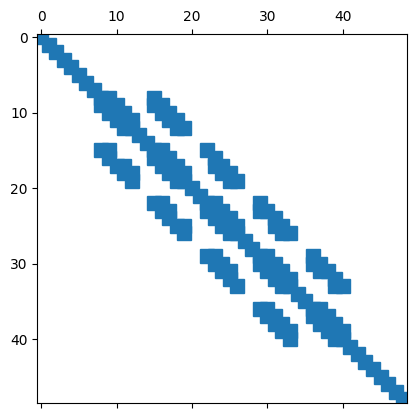

solve.A.shape=(49, 49) solve.B.shape=(49,) U.shape=(49,) trigrid.V.shape=(49, 2, 1)


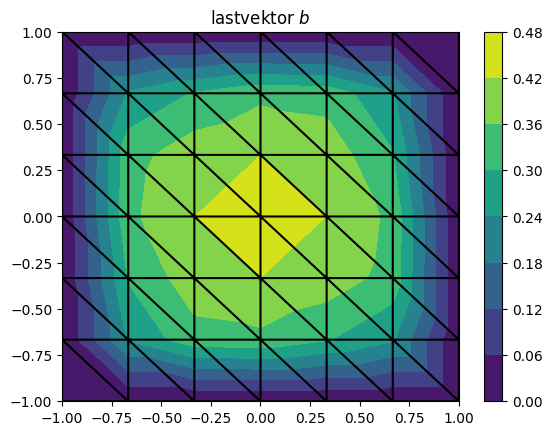

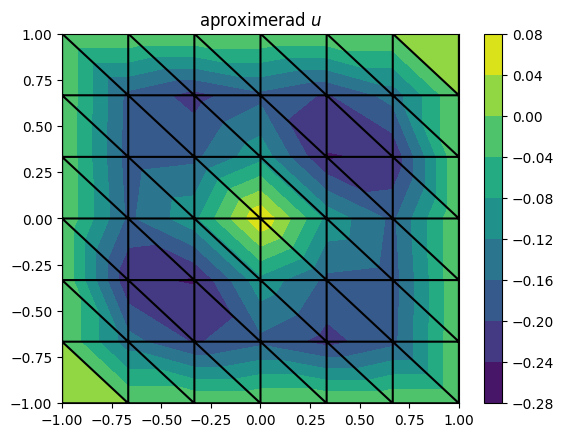

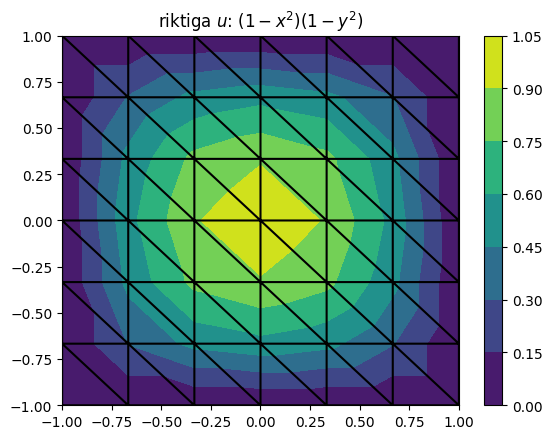

In [1121]:
import scipy

def dot2(a: Vector2, b: Vector2) -> float:
    assert a.size == 2,1 == b.size
    return np.dot(a[:,0], b[:,0])

def a_integrand(i: AkIntegrand) -> float:
    def beta(pos: Vector2) -> Vector2:
        (x,), (y,) = pos
        return np.asarray([[-y], [-x]])
    epsilon = 1.0
    ret = dot2(epsilon * i.nabla_u, i.nabla_v) + dot2(beta(i.x), i.nabla_u) * i.v
    #print(f"ε∇{npfmt(i.nabla_u)} . {npfmt(i.nabla_v)}"
    #      f"+ {npfmt(beta(i.x))} . ∇{npfmt(beta(i.nabla_u))}{float(i.v)}"
    #      f" -> {ret}")
    return ret

def b_integrand(i: AkIntegrand) -> float:
    def f(pos: Vector2) -> float:
        (x,), (y,) = pos
        return 2*(2-x**2-y**2)-2*x*y*(x**2-y**2)
    #print(f"f({npfmt(i.x)}) = {f(i.x)}")
    return f(i.x) * i.v

def test_solve():
    rx = 6
    trigrid = TriangulatedGrid(nx=rx, ny=rx, xmin=-1, xmax=1, ymin=-1, ymax=1)
    solve = StiffnessMatrixSolve2d(
        trigrid=trigrid,
        a_integrand=a_integrand,
        b_integrand=b_integrand,
    )
    plt.spy(solve.A)
    plt.show()
    U: ndarray = scipy.sparse.linalg.spsolve(solve.A, solve.B)
    print(f"{solve.A.shape=} {solve.B.shape=} {U.shape=} {trigrid.V.shape=}")
    #print(f"A={solve.A}")
    #print(f"B={solve.B}")

    show_trigrid_evaluated(trigrid, solve.B, title="lastvektor $b$")
    show_trigrid_evaluated(trigrid, U, title="aproximerad $u$")

    U_real = (1-np.pow(trigrid.xs, 2)) * (1-np.pow(trigrid.ys, 2))
    show_trigrid_evaluated(trigrid, U_real, "riktiga $u$: $(1-x^2)(1-y^2)$")

test_solve()
